## Test of the Graph Hierarchies

In [1]:
%matplotlib inline

import os.path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
from scipy.spatial.transform import Rotation

from pygsp import graphs, filters, plotting, reduction
from fgsp.graph.wavelet_evaluator import WaveletEvaluator
from fgsp.graph.global_graph import GlobalGraph
from fgsp.common.config import ClientConfig
from fgsp.controller.signal_handler import SignalHandler
from fgsp.classifier.top_classifier import TopClassifier

%load_ext autoreload
%autoreload 2

plotting.BACKEND = 'matplotlib'
plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
def create_signal_from_traj(traj):
    traj_origin = traj[0,:]
    pos_signal = (traj - traj_origin).squeeze()
    x_pos = np.linalg.norm(pos_signal, ord=2, axis=1)
    return x_pos

## 1. Test of Simple Displacement

[1661263122305447.0] GlobalGraph: Initialized.
[1661263122620070.0] GlobalGraph: Initialized.


(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Graph(n_vertices=9, n_edges=29)'}>)

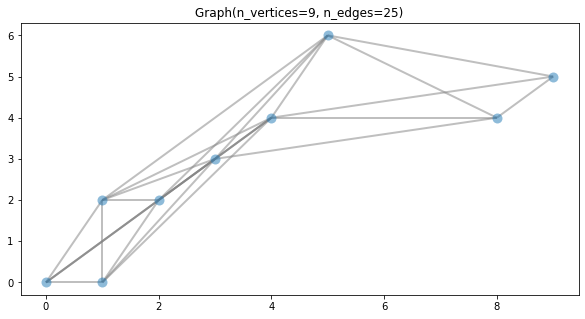

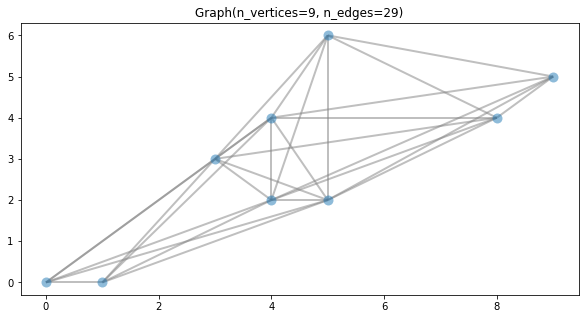

In [77]:
config = ClientConfig()
config.construction_method = 'r3'

opt_traj = np.array([[0,0,0,0,0],[0,1,1,0,1],[0,2,1,2,1],[1,3,2,2,1],[1,4,3,3,1],[1,5,4,4,1],[2,6,5,6,2], [2,7,8,4,2], [2,8,9,5,2]])
opt_graph = GlobalGraph(config)
opt_graph.build_from_poses(opt_traj[:,2:])
opt_graph.G.plot()

est_traj = np.array([[0,0,0,0,0],[0,1,1,0,1],[0,2,4,2,1],[1,3,5,2,1],[1,4,3,3,1],[1,5,4,4,1],[2,6,5,6,2], [2,7,8,4,2], [2,8,9,5,2]])
est_graph = GlobalGraph(config)
# est_graph.build_from_poses(est_traj[:,2:])
# est_graph.G.coords = est_traj[:,2:]
est_graph.build_from_poses(est_traj[:,2:])
est_graph.G.plot()


[1661263130513771.0] WaveletEvaluator: Computing wavelets for 6 scales.
[1661263130515251.5] WaveletEvaluator: Computing wavelets for 6 scales.


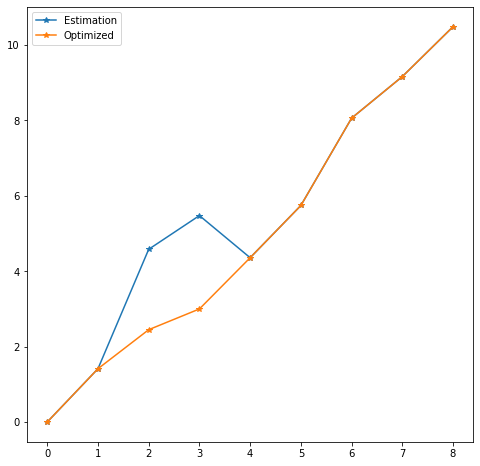

In [78]:
# Compute wavelets
n_scales = 6
opt_eval = WaveletEvaluator(n_scales)
opt_psi = opt_eval.compute_wavelets(opt_graph.G)

est_eval = WaveletEvaluator(n_scales)
# opt_psi = est_eval.compute_wavelets(opt_graph.G)
est_psi = est_eval.compute_wavelets(opt_graph.G)

# Compute signal
robot = 'robot'
opt_signal = SignalHandler(config)
opt_signal.convert_signal_from_poses(opt_traj, robot)
est_signal = SignalHandler(config)
est_signal.convert_signal_from_poses(est_traj, robot)

all_est_nodes = est_signal.get_all_nodes(robot)
all_opt_nodes = opt_signal.get_all_nodes(robot)
x_est = est_signal.compute_signal(all_est_nodes)
x_opt = opt_signal.compute_signal(all_opt_nodes)

fig, axes = plt.subplots(1, 1, figsize=(8, 8))
fig.subplots_adjust(hspace=0.5)

axes.plot(x_est, '-*', label='Estimation')
axes.plot(x_opt, '-*', label='Optimized')
axes.legend()

In [81]:
# Compute wavelet coefficients and features
W_est = est_eval.compute_wavelet_coeffs(x_est)
W_opt = opt_eval.compute_wavelet_coeffs(x_opt)
features = est_eval.compute_features(W_opt, W_est)

top_n = 2
classifier = TopClassifier(top_n)
labels = classifier.classify(features)

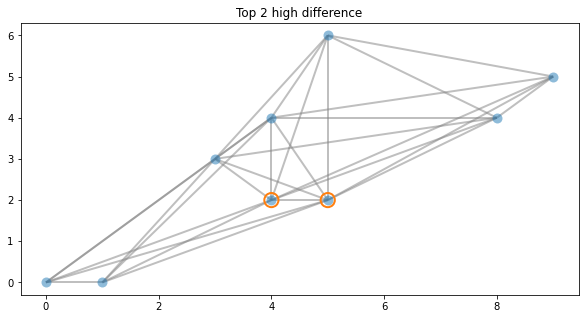

In [82]:
classified_labels = [l != None for l in labels]
peaks = np.where(classified_labels)
_ = est_graph.G.plot(title=f'Top {top_n} high difference', highlight=peaks)

## Let's Build Hierarchies!